In [1]:
# Scientific libraries
import numpy as np
import scipy.stats as stats
import scipy.special as sf
import scipy.integrate as integrate
import scipy.interpolate as interpolate

# import Pandas

import pandas as pd

#astro
from astropy.cosmology import WMAP9 as cosmo
import astropy.io.fits as fits
import astropy.units as u
import astropy.constants as const

# Graphic libraries


%matplotlib notebook
import matplotlib.pyplot as plt


from jupyterthemes import jtplot
jtplot.style(context='notebook', fscale=1,
            # grid='off'
            
            )
import seaborn as sns


from glob import glob
import copy
import collections
#import warnings
#warnings.simplefilter('ignore')

import pystan
from vapeplot import vapeplot

vapeplot.set_palette('vaporwave')

In [2]:
def dNdz(z,r0,a, b):
    
    return r0 * np.power(z+1,a) * np.exp(-z/b)
    

In [3]:
def draw_luminosity(mu, sigma, size=1):
    xs_all = np.exp(mu + sigma*np.random.randn(size))
    return xs_all

In [4]:
def draw_fobs(L,z, sigma,size=1):
    
    f = L/ (4 * np.pi * (z+1)**2)
    
    return np.exp(np.log(f) + sigma*np.random.randn(size))

In [5]:
def draw_zs(r0, alpha, beta, zmax):
    zs = np.linspace(0, zmax, 1000)
    dndzs = dNdz(zs, r0, alpha, beta)
    ymax = np.max(dndzs)
    Nex = integrate.quad(dNdz,0.,zmax,args=(r0,alpha, beta))[0]
    Ndraw = np.random.poisson(Nex)
    igen = 0
    while igen < Ndraw:
        y = np.random.uniform(low=0, high=ymax)
        z = np.random.uniform(low=0, high=zmax)
        if y < dNdz(z, r0, alpha, beta):
            igen += 1
            yield z

In [6]:
def draw_survey(r0,a,b, mu, sigma, fsigma,zsigma,Fth, zmax):
    
    # first draw the redshifts
    zsample = np.array([z for z in draw_zs(r0, a, b, zmax)])
    
    n = len(zsample)
    
    Ls = draw_luminosity(mu, sigma, size=n)
    
    
    Fobs = draw_fobs(Ls, zsample,fsigma,size=n)
    
  
        
    sel = Fobs > Fth
    
    zobs = np.exp(np.log(zsample) + zsigma* np.random.normal(size=n))
  
    z99obs = np.percentile(zsample[sel], 99)
    
    print('99th percentile of observed galaxy redshifts is %.2f'%z99obs)
    
    print(sum(sel), sum(~sel))

    return dict(Fobs=Fobs[sel],Ltrue=Ls,ztrue=zsample, zobs=zobs[sel],sel=sel)

In [7]:
np.random.seed(9128347)

r0_true = 100
a_true = 2.
b_true= 1.
mu_true = 2.
sigma_true = .5
Fth = 1./(4*np.pi)

Fsigma= .05
zsigma=.05
zmax = 10.
survey = draw_survey(r0_true,
                     a=a_true,
                     b=b_true,
                     mu=mu_true,
                     sigma=sigma_true,
                     fsigma=Fsigma,
                     zsigma=zsigma,
                     Fth=Fth,
                     zmax=zmax)






#selection = survey_df.sel

99th percentile of observed galaxy redshifts is 2.61
(207, 251)


<IPython.core.display.Javascript object>


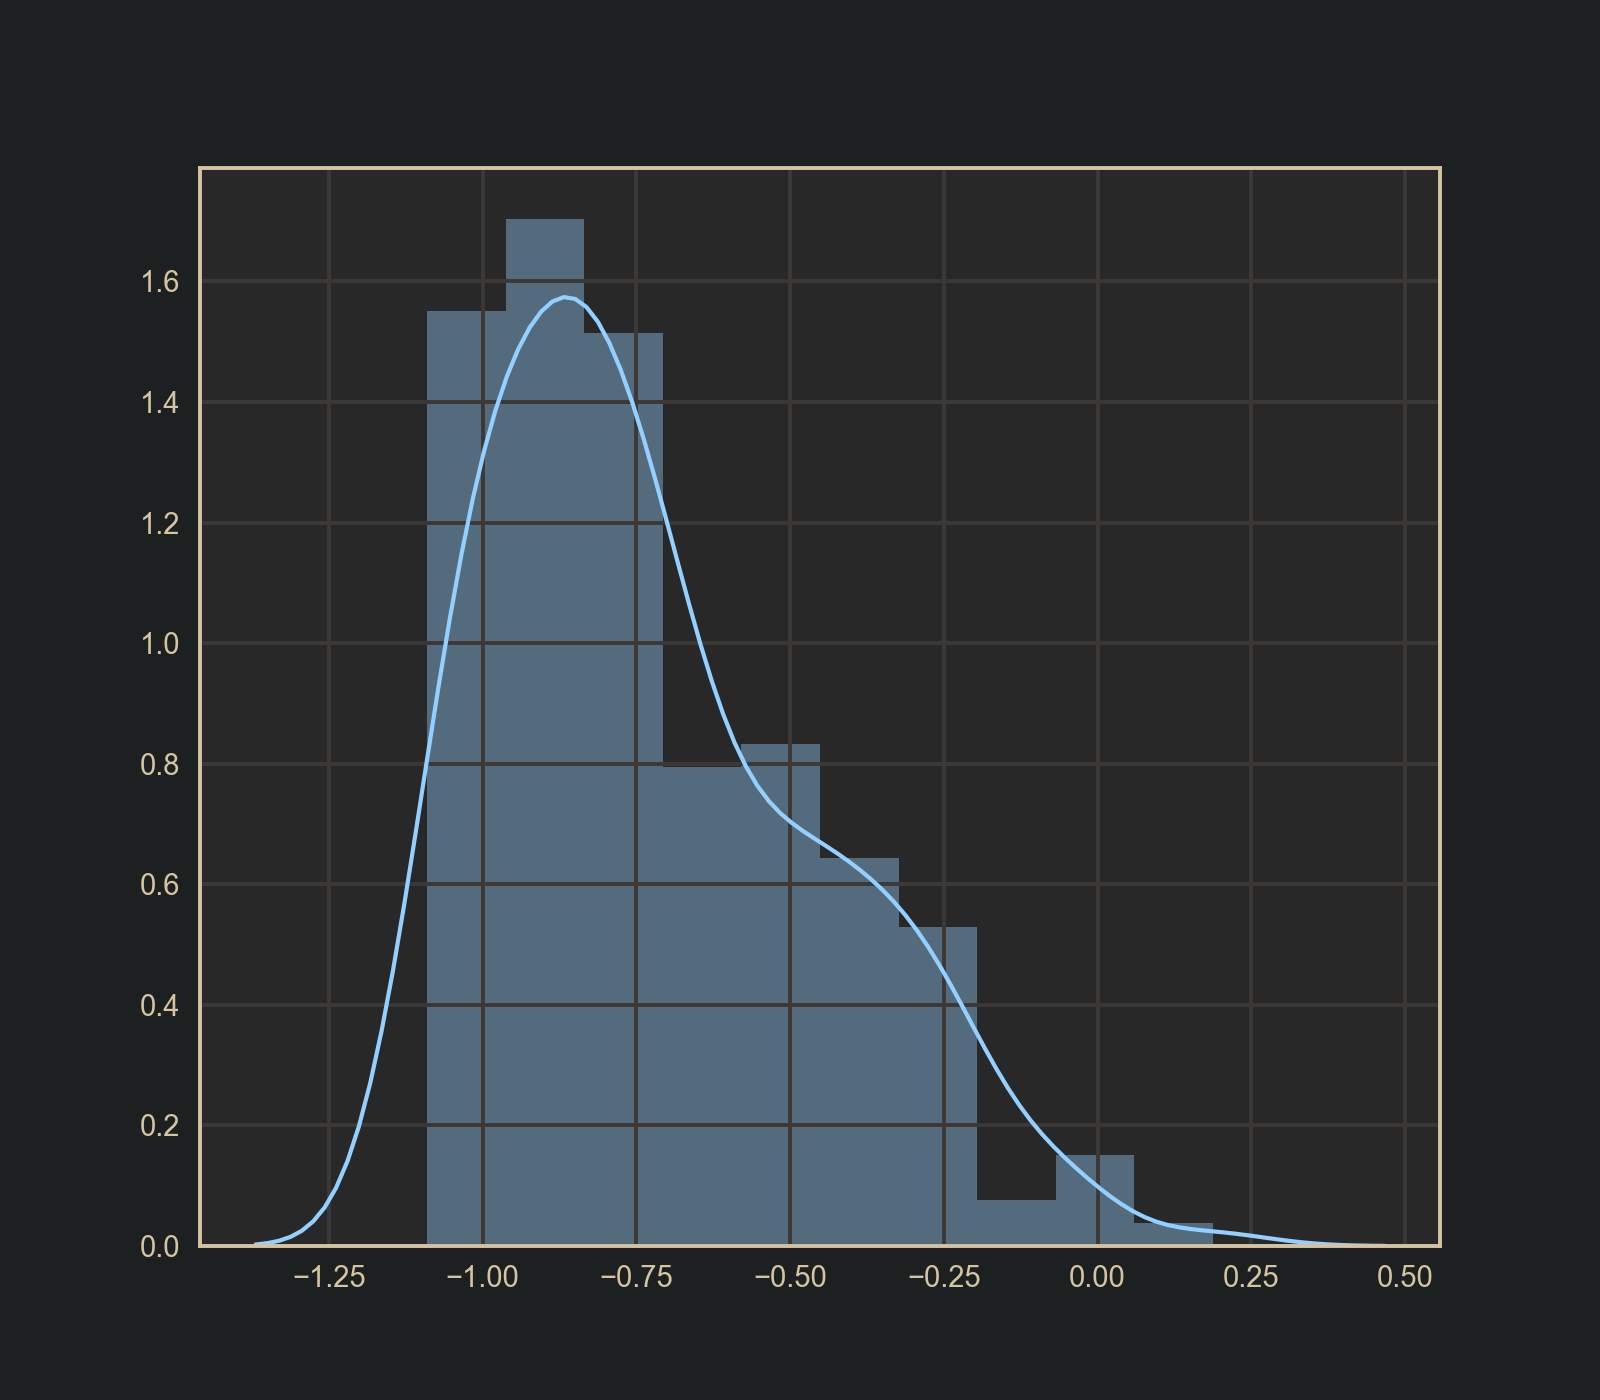

/home/jburgess/.venv/science/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [8]:
fig, ax = plt.subplots()


sns.distplot(np.log10(survey['Fobs']))


#ax.hist(np.linspace(0,100))

<IPython.core.display.Javascript object>


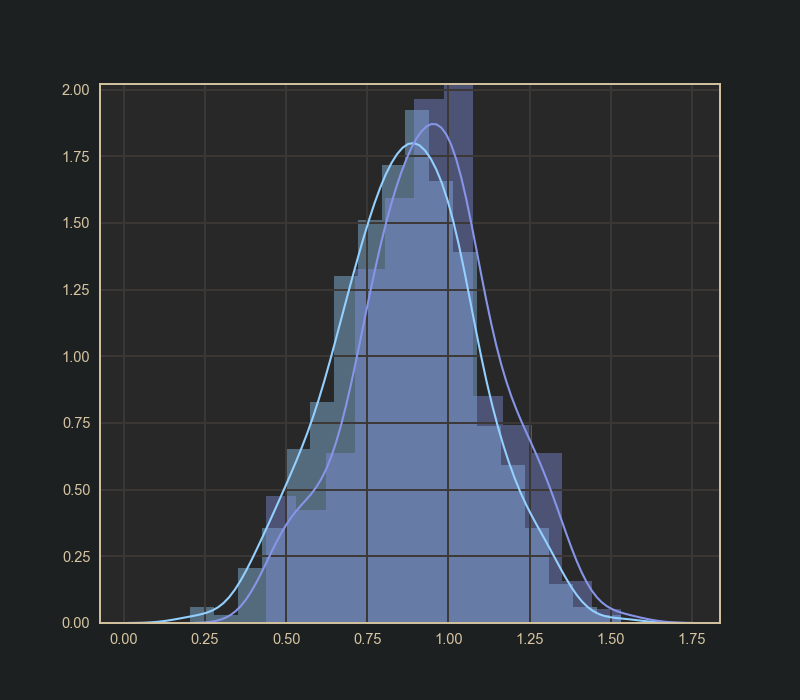

In [39]:
fig, ax = plt.subplots()

bins = np.linspace(-0,1,10)
sns.distplot(np.log10(survey['Ltrue']),
        #bins=bins
       )
sns.distplot(np.log10(survey['Ltrue'])[survey['sel']],
       # bins=bins
       )

<IPython.core.display.Javascript object>


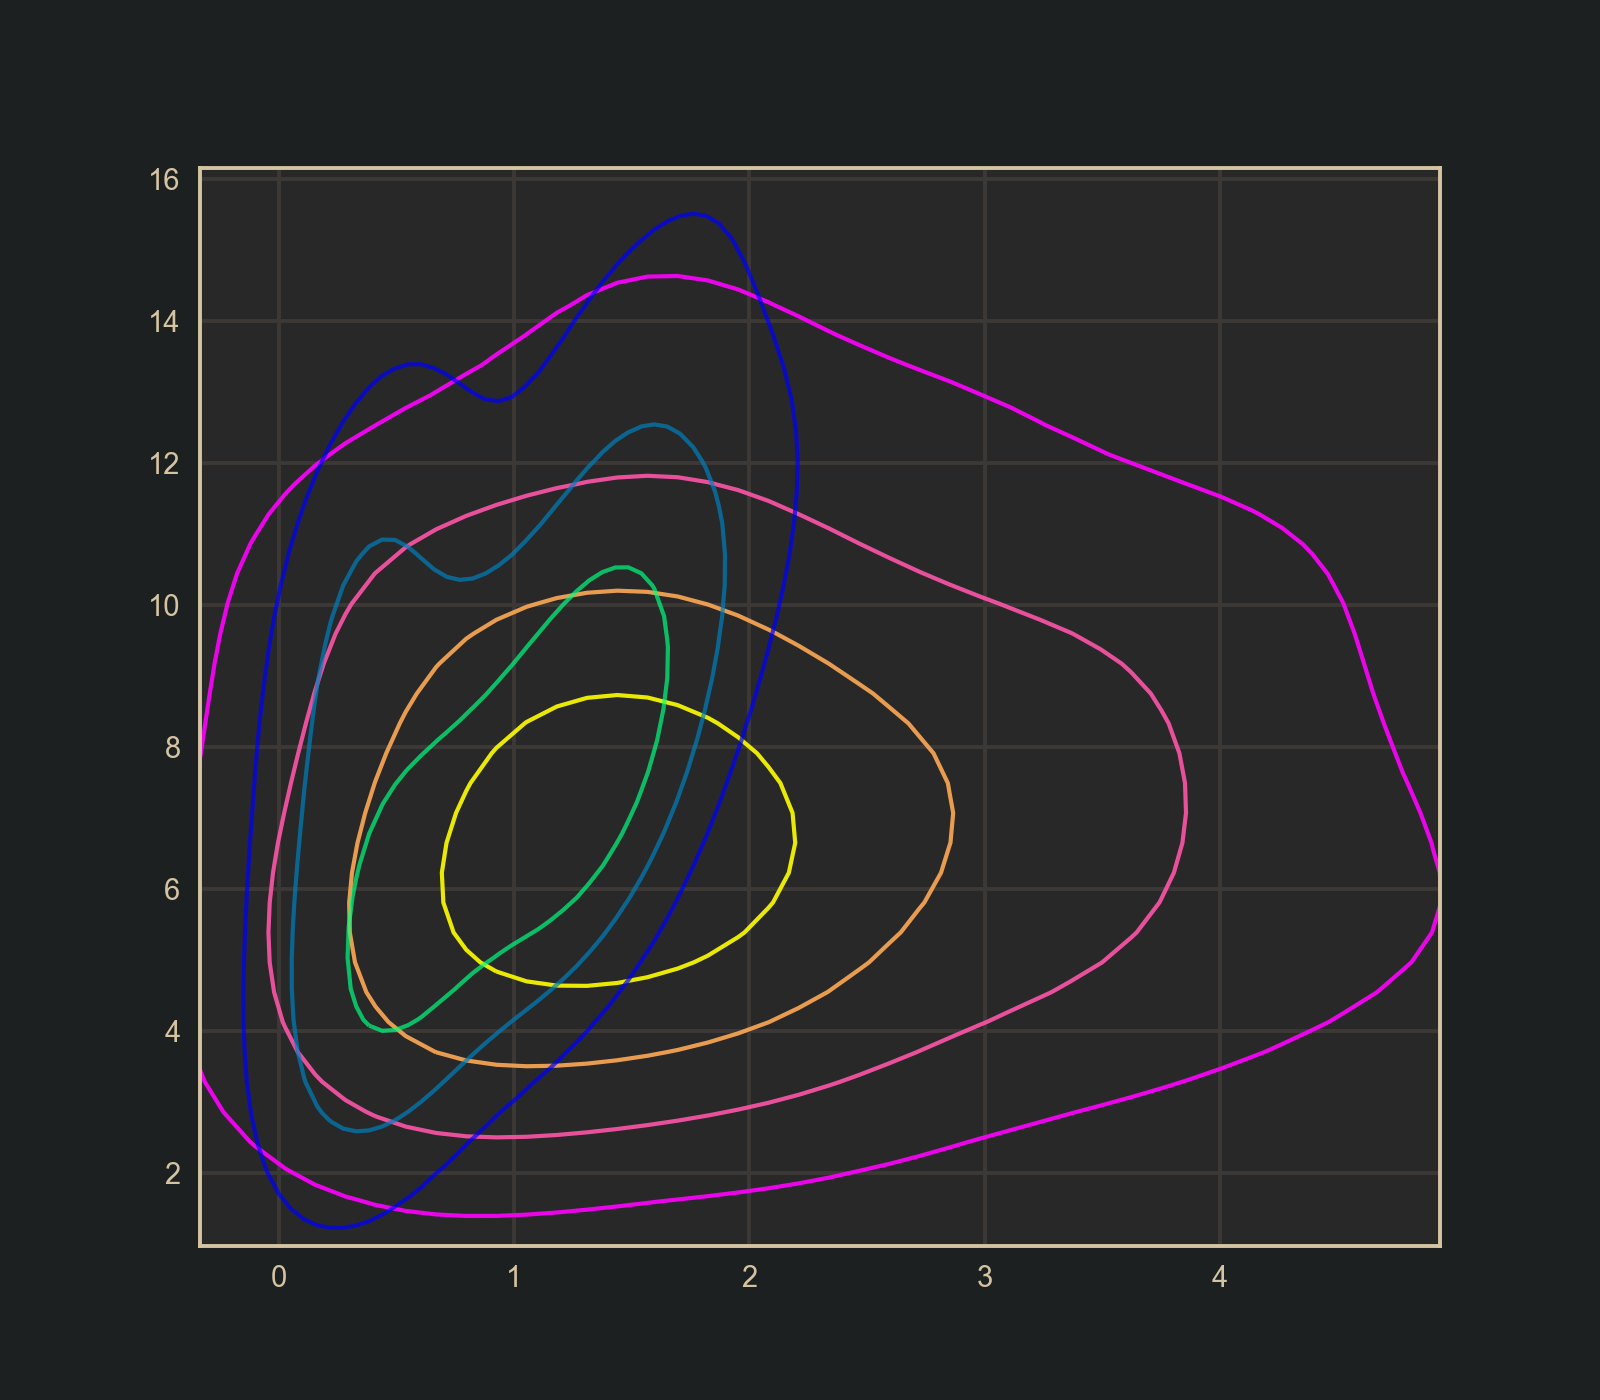

/home/jburgess/.venv/science/local/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


In [9]:
fig, ax = plt.subplots()


sns.kdeplot(
    survey['ztrue'],
    (survey['Ltrue']),
    
    
    shade=False,
    shade_lowest=False,
    
    cmap='spring',
    alpha=0.9,
    n_levels=4


);

sns.kdeplot(
    
    
    survey['ztrue'][survey['sel']],
    (survey['Ltrue'][survey['sel']]),
    
    shade=False,
    shade_lowest=False,
    
    cmap='winter',
    alpha=0.7,
    n_levels=4,
    linewidth=6


);




In [8]:
model = pystan.StanModel(file='flux.stan', model_name='flux_fit')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL flux_fit_e1cf93a9ad7e7a4fd7330b8d64bc5d03 NOW.


In [9]:
zmodel = np.linspace(0,10,500)

In [10]:
fit = model.sampling(
    data = {'Nobs': len(survey['Fobs']), 
            'Fobs': survey['Fobs'],
            'sigma_F_obs': Fsigma,
            'Nnobs_max': 300,            
            'Fth': Fth,
            'zmax': zmax,
            'zs_model': zmodel,
            'nmodel': 500},
    iter = 16000,
    #warmup=3000,
    thin = 4,
    seed=194838
)

/home/jburgess/.venv/science/local/lib/python2.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


<IPython.core.display.Javascript object>


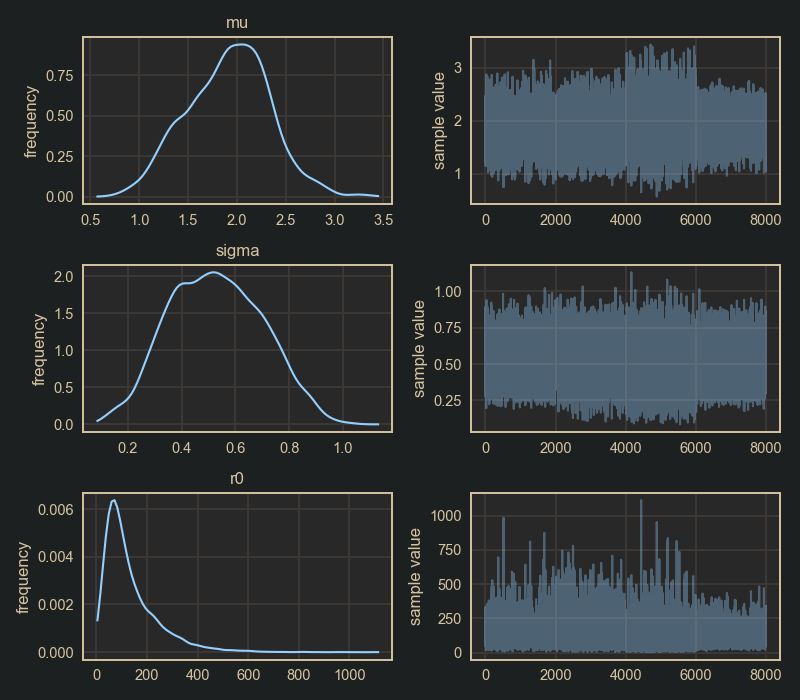

In [11]:
fig = fit.plot(['mu', 'sigma', 'r0'])


plt.tight_layout()

<IPython.core.display.Javascript object>


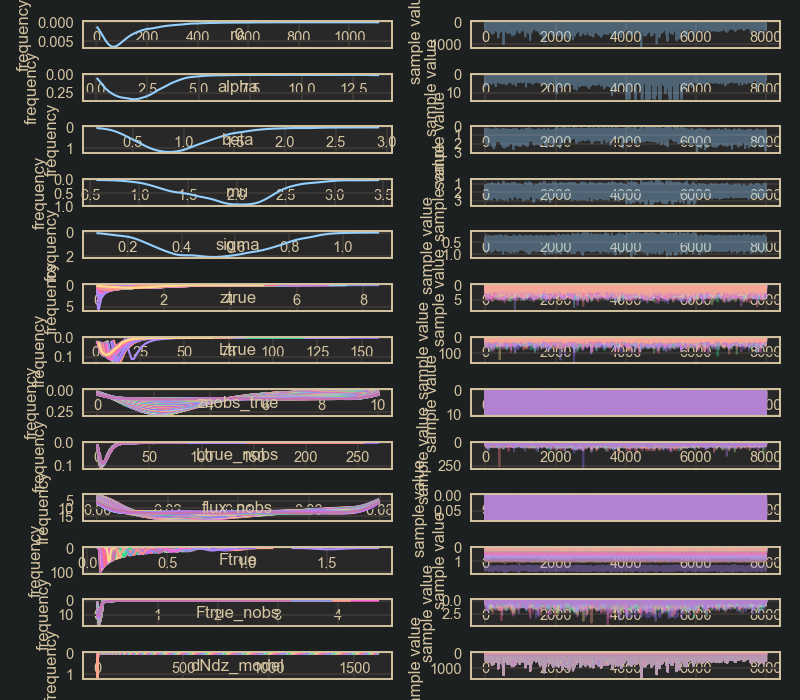

In [12]:


fig = fit.plot()


plt.tight_layout()

In [13]:
plt.tight_layout?

In [26]:
chain_selected = fit.extract(permuted=True)

In [14]:
fig, ax = plt.subplots()
mallsoft = vapeplot.palette("mallsoft")



ax.fill_between(zmodel, np.percentile(chain_selected['dNdz_model'], 97.5, axis=0), np.percentile(chain_selected['dNdz_model'], 2.5, axis=0), color=mallsoft[-1], alpha=1)
ax.fill_between(zmodel, np.percentile(chain_selected['dNdz_model'], 84, axis=0), np.percentile(chain_selected['dNdz_model'], 16, axis=0), color=mallsoft[-2], alpha=1)
ax.plot(zmodel, np.median(chain_selected['dNdz_model'], axis=0),color=mallsoft[-3],label='fit dN/dz')
ax.plot(zmodel, dNdz(zmodel, r0_true, a_true, b_true), '--', color='white',label='true dN/nz')

ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\frac{dN}{dz}$')
ax.grid(False)

#ax.axvline(6,color='red',label='threshold')
ax.set_xlim(0,10)
ax.legend()

#fig.savefig('final.pgf')

<IPython.core.display.Javascript object>

NameError: name 'chain_selected' is not defined

<IPython.core.display.Javascript object>


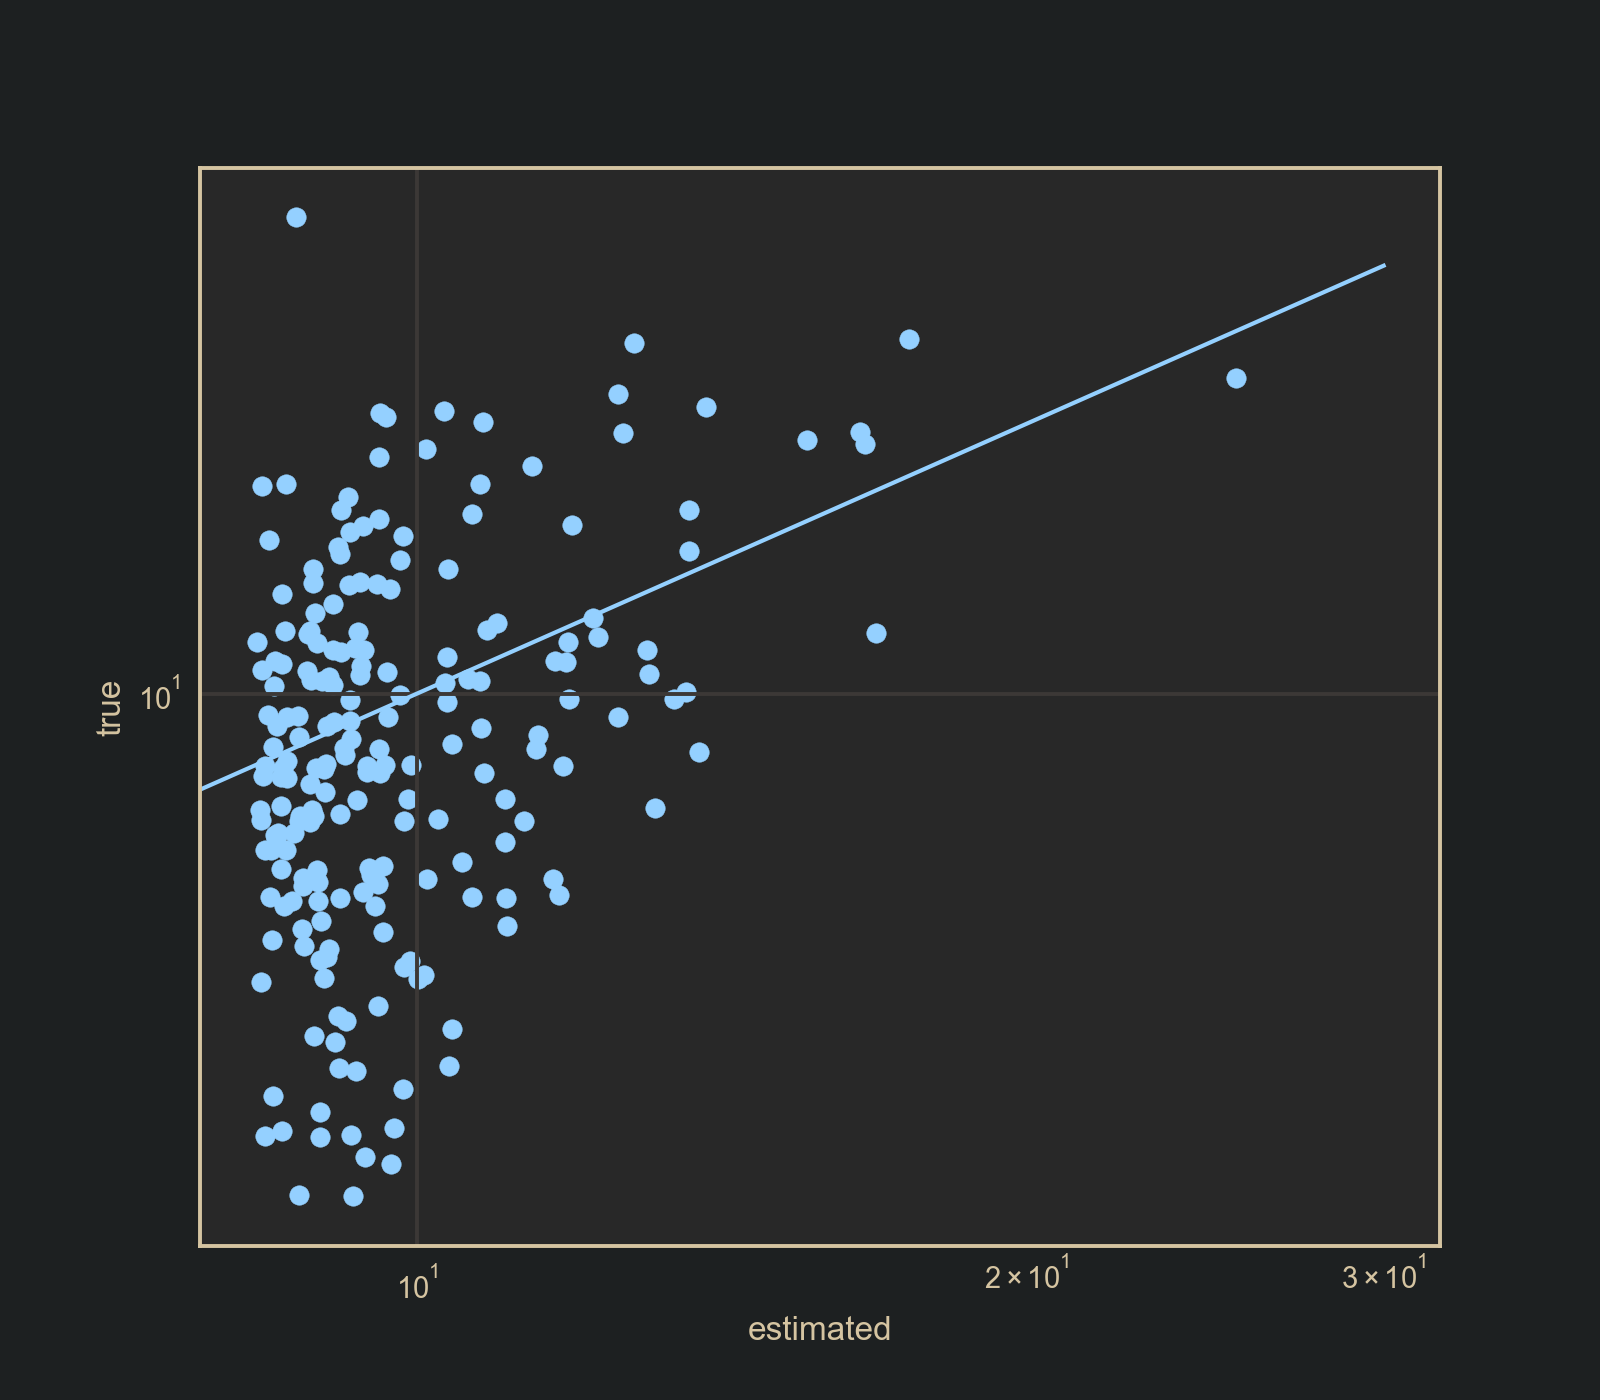

In [33]:
fig, ax = plt.subplots()




ax.scatter(chain_selected['Ltrue'].mean(axis=0),survey['Ltrue'][survey['sel']])
ax.plot([0,30], [0,30])
ax.set_xlabel('estimated')
ax.set_ylabel('true')
ax.set_xscale('log')
ax.set_yscale('log')

<IPython.core.display.Javascript object>


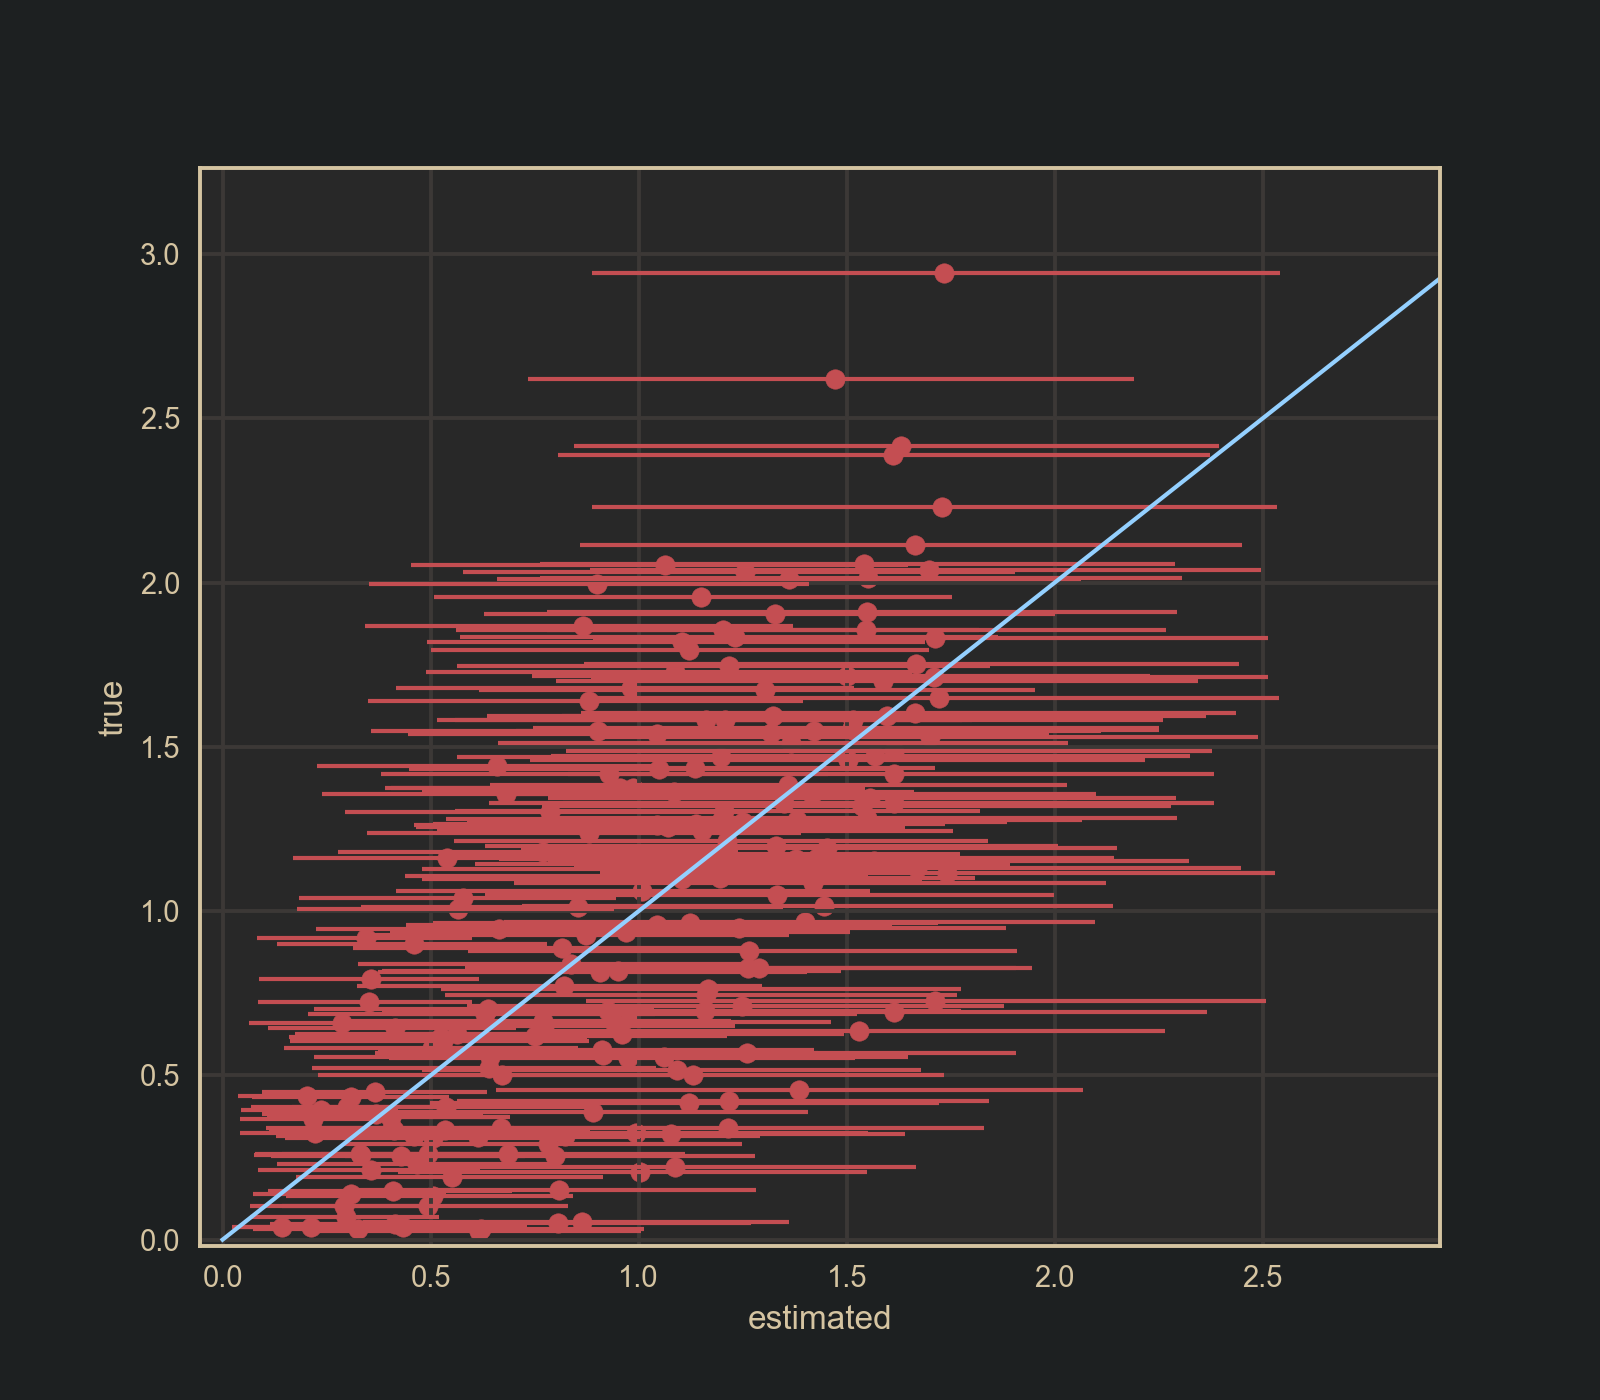

Text(0,0.5,'true')

In [29]:
fig, ax = plt.subplots()

ax.scatter(chain_selected['ztrue'].mean(axis=0),survey['ztrue'][survey['sel']],c='r')

ax.plot([0,6], [0,6])


ax.hlines(survey['ztrue'][survey['sel']], np.percentile(chain_selected['ztrue'], 16, axis=0),
          np.percentile(chain_selected['ztrue'], 84, axis=0),colors='r')

ax.set_xlabel('estimated')
ax.set_ylabel('true')

In [47]:
np.percentile(chain_selected['ztrue'], 97.5, axis=0)

(207,)

In [28]:
fit

Inference for Stan model: flux_fit_307b5d7360014230b56643355412af92.
4 chains, each with iter=32000; warmup=16000; thin=8; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
r0              125.38    4.97   88.5  26.59  68.06 105.59 156.88 359.36  317.0   1.01
alpha             1.59    0.04   0.89   0.29   0.92   1.48   2.12   3.59  573.0   1.02
beta               1.3    0.07   0.45   0.54   0.99   1.26   1.56   2.33   41.0   1.06
mu                 1.9    0.02   0.39   1.06   1.66   1.91   2.16    2.6  259.0   1.02
sigma             0.55    0.01   0.17   0.25   0.43   0.54   0.66   0.91  273.0   1.02
ztrue[0]          1.61    0.03   0.77   0.28   1.06   1.57    2.1   3.22  753.0    1.0
ztrue[1]          0.54  8.3e-3   0.38   0.03   0.25   0.48   0.75   1.43 2077.0    1.0
ztrue[2]          0.37  4.4e-3    0.3   0.01   0.14    0.3   0.52   1.12 4701.0    1.0
ztrue[3]          1.21    0.

In [28]:
model_nc = pystan.StanModel(file='flux_non_cent.stan', model_name='flux_fit')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL flux_fit_6926c8a0005ca8739be2edd3c931aaf7 NOW.


In [ ]:
fit_nc = model_nc.sampling(
    data = {'Nobs': len(survey['Fobs']), 
            'Fobs': survey['Fobs'],
            'sigma_F_obs': Fsigma,
            'Nnobs_max': 300,            
            'Fth': Fth,
            'zmax': zmax,
            'zs_model': zmodel,
            'nmodel': 500},
    iter = 32000,
    #warmup=3000,
    thin = 8,
    seed=194838
)

<IPython.core.display.Javascript object>


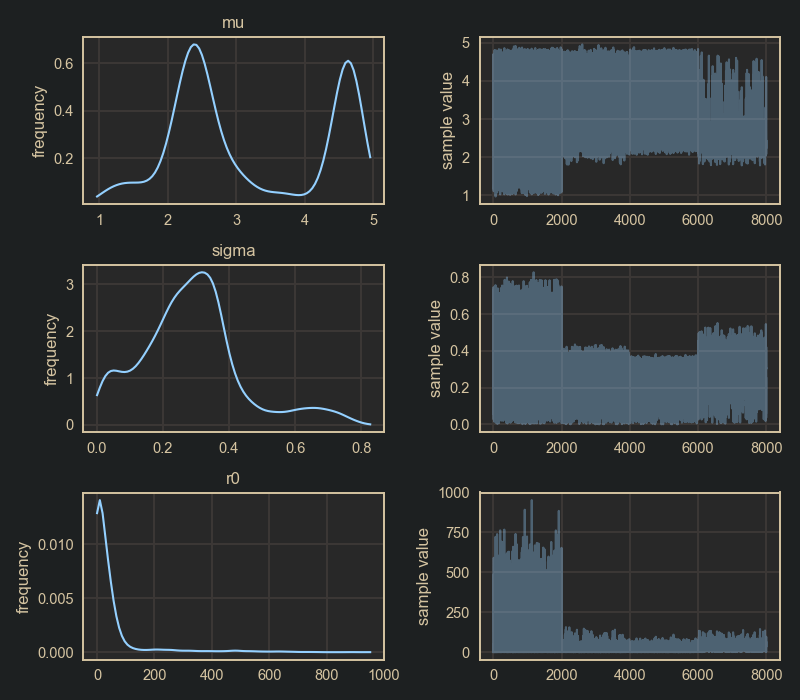

In [30]:
fig = fit_nc.plot(['mu', 'sigma', 'r0'])


plt.tight_layout()

<IPython.core.display.Javascript object>


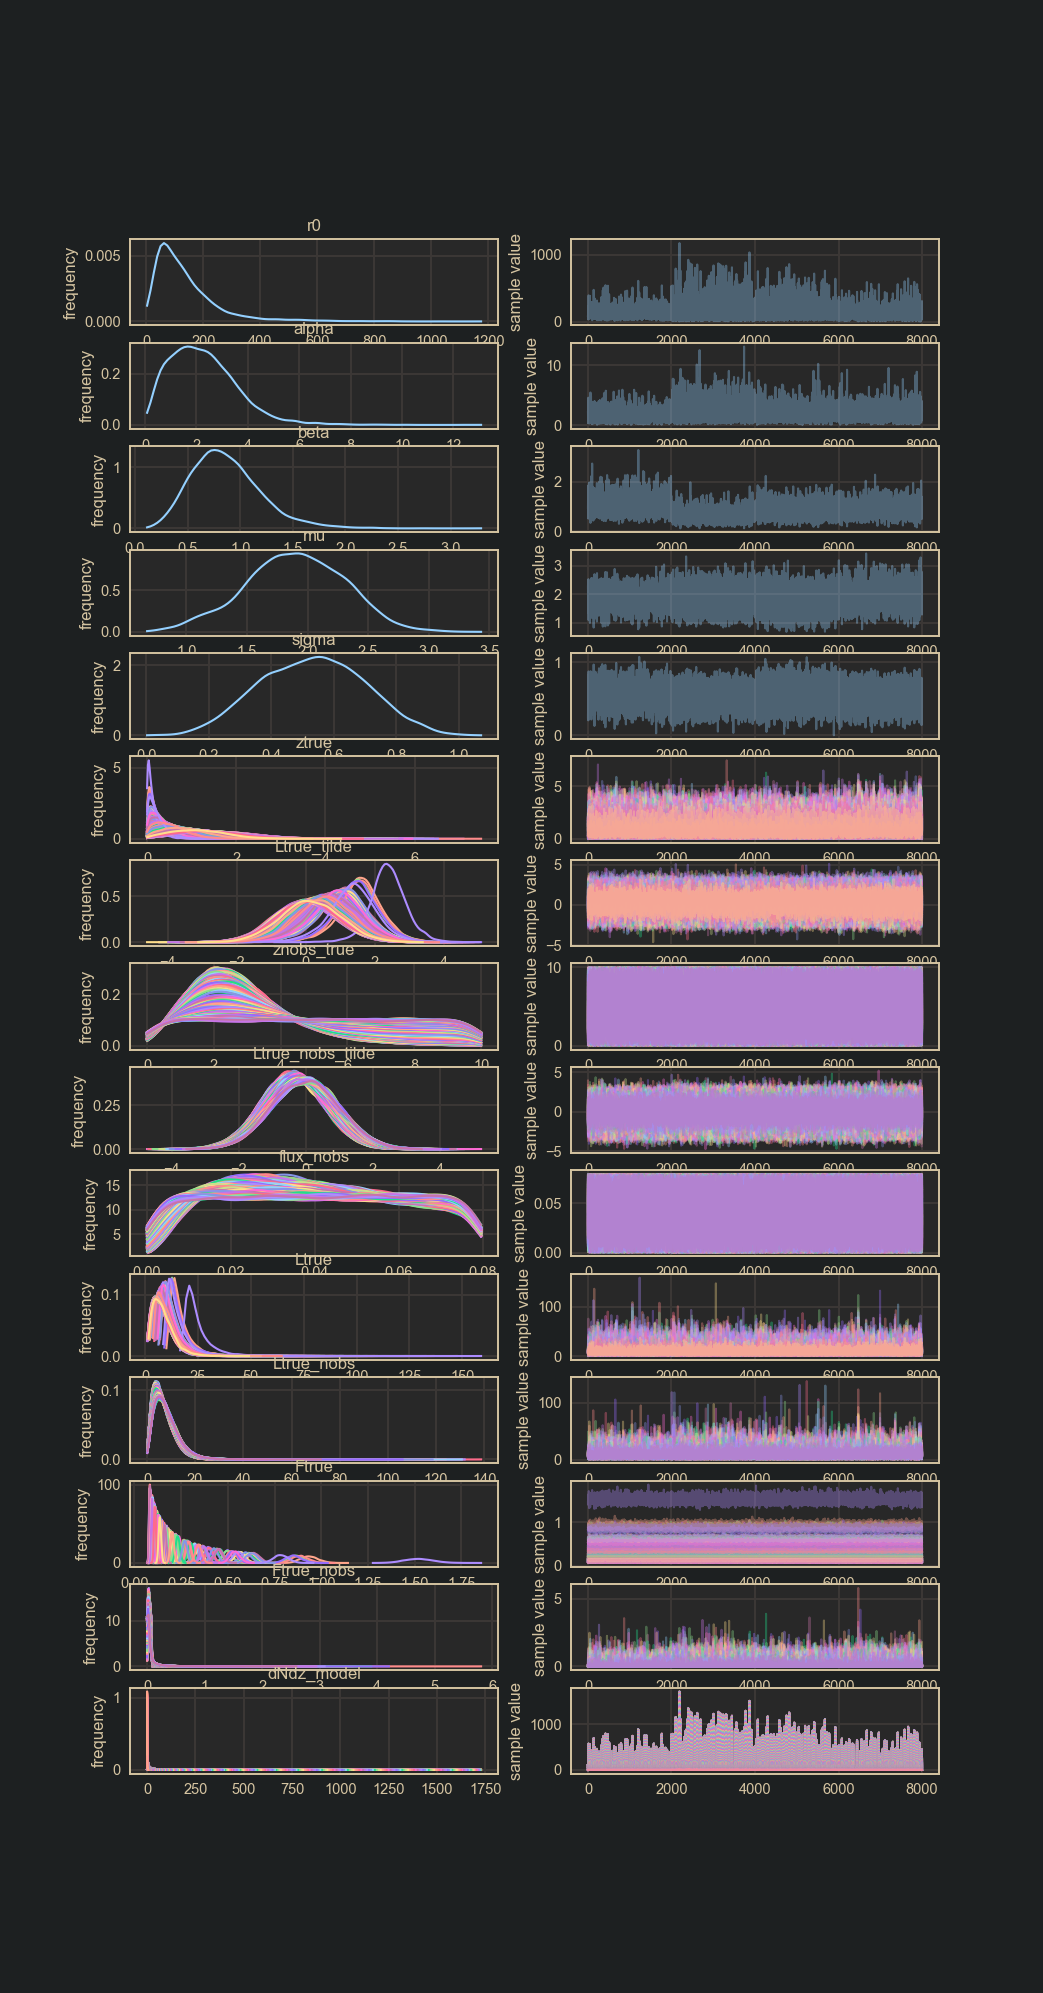

In [24]:
fig = fit_nc.plot()

In [25]:
chain_selected = fit_nc.extract(permuted=True)

<IPython.core.display.Javascript object>


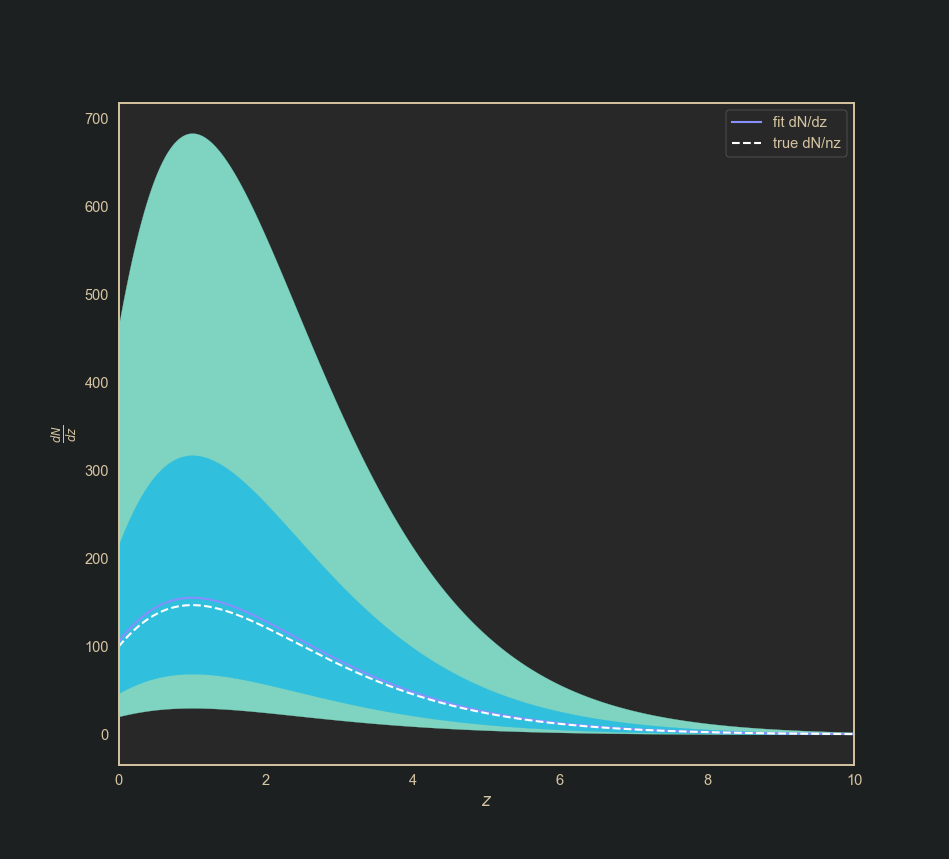

In [26]:
fig, ax = plt.subplots()
mallsoft = vapeplot.palette("mallsoft")



ax.fill_between(zmodel, np.percentile(chain_selected['dNdz_model'], 97.5, axis=0), np.percentile(chain_selected['dNdz_model'], 2.5, axis=0), color=mallsoft[-1], alpha=1)
ax.fill_between(zmodel, np.percentile(chain_selected['dNdz_model'], 84, axis=0), np.percentile(chain_selected['dNdz_model'], 16, axis=0), color=mallsoft[-2], alpha=1)
ax.plot(zmodel, np.median(chain_selected['dNdz_model'], axis=0),color=mallsoft[-3],label='fit dN/dz')
ax.plot(zmodel, dNdz(zmodel, r0_true, a_true, b_true), '--', color='white',label='true dN/nz')

ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\frac{dN}{dz}$')
ax.grid(False)

#ax.axvline(6,color='red',label='threshold')
ax.set_xlim(0,10)
ax.legend()

In [27]:
fit_nc

Inference for Stan model: flux_fit_e84415943246baa540722962070523e4.
4 chains, each with iter=16000; warmup=8000; thin=4; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
r0                    135.96    8.99 114.09  20.57  60.09 105.69 174.26 464.72  161.0   1.01
alpha                   2.27    0.29   1.31   0.37   1.29    2.1   3.03   5.25   21.0   1.08
beta                    0.87    0.11   0.33   0.33   0.64   0.83   1.06   1.64    9.0   1.21
mu                       1.9    0.03   0.41   1.07   1.62    1.9   2.19   2.66  167.0   1.02
sigma                   0.53    0.01   0.17   0.22   0.41   0.53   0.65   0.86  182.0   1.02
ztrue[0]                1.54    0.04   0.77   0.21   0.97    1.5   2.04   3.14  423.0   1.01
ztrue[1]                0.52    0.01   0.37   0.03   0.24   0.46   0.74   1.37 1083.0    1.0
ztrue[2]                0.36  6.7e-3   0.29   0.02   0.15    0.3   0